In [4]:
import torch
import matplotlib.pyplot as plt
import pytorch_mask_rcnn as pmr
from PIL import Image
import os
from torchvision.transforms import transforms
import json
import numpy as np
import pycocotools

use_cuda = True
dataset = "coco"
ckpt_path = "/data/zihaosh/hw2_load/hw3-xco-80.pth"
data_dir = "/data/zihaosh/data_hw3"

device = torch.device("cuda" if torch.cuda.is_available() and use_cuda else "cpu")
if device.type == "cuda":
    pmr.get_gpu_prop(show=True)
print("\ndevice: {}".format(device))



cuda: True
available GPU(s): 1
0: {'name': 'GeForce GTX 1080 Ti', 'capability': [6, 1], 'total_momory': 10.92, 'sm_count': 28}

device: cuda


In [9]:
ds = pmr.datasets(dataset, data_dir, "val", train=False)

/data/zihaosh/data_hw3/val.json
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [10]:
ds[2][0]

tensor([[[0.2627, 0.2706, 0.2667,  ..., 0.4980, 0.6549, 0.7725],
         [0.2667, 0.2706, 0.2784,  ..., 0.5922, 0.7020, 0.7961],
         [0.2353, 0.2431, 0.2980,  ..., 0.6471, 0.7529, 0.8039],
         ...,
         [0.4627, 0.4667, 0.4706,  ..., 0.5294, 0.5373, 0.5490],
         [0.4824, 0.5137, 0.5529,  ..., 0.5373, 0.5333, 0.5059],
         [0.5216, 0.5373, 0.5098,  ..., 0.5843, 0.5647, 0.5412]],

        [[0.1765, 0.1882, 0.1843,  ..., 0.3373, 0.5020, 0.6196],
         [0.1804, 0.1882, 0.1961,  ..., 0.4275, 0.5412, 0.6431],
         [0.1608, 0.1608, 0.2157,  ..., 0.4784, 0.5922, 0.6745],
         ...,
         [0.4235, 0.4275, 0.4314,  ..., 0.5098, 0.5176, 0.5294],
         [0.4431, 0.4745, 0.5137,  ..., 0.5176, 0.5137, 0.4863],
         [0.4824, 0.4980, 0.4706,  ..., 0.5608, 0.5373, 0.5137]],

        [[0.1216, 0.1216, 0.1176,  ..., 0.2510, 0.3882, 0.4902],
         [0.1255, 0.1216, 0.1294,  ..., 0.3294, 0.4235, 0.5216],
         [0.1020, 0.0941, 0.1490,  ..., 0.3529, 0.4745, 0.

In [13]:
# indices = torch.randperm(len(ds)).tolist()
indices = [i+1 for i in range(100)]
d = torch.utils.data.Subset(ds, indices)

In [15]:

model = pmr.maskrcnn_resnet50(False, len(ds.classes) + 1).to(device)
model.eval()
model.head.score_thresh = 0.3



if ckpt_path:
    checkpoint = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(checkpoint["model"])
#     print(checkpoint["eval_info"])
#     del checkpoint
    torch.cuda.empty_cache()
    
for p in model.parameters():
    p.requires_grad_(False)
    
    


******************** True


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 590.83 MiB already allocated; 14.56 MiB free; 1.17 MiB cached)

In [16]:
iters = 1

for i, (image, target) in enumerate(d):
    image = image.to(device)
    target = {k: v.to(device) for k, v in target.items()}
    
    with torch.no_grad():
        result = model(image)
        
    plt.figure(figsize=(12, 15))
    pmr.show(image, result, ds.classes)

    if i >= iters - 1:
        break

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 590.83 MiB already allocated; 14.56 MiB free; 1.17 MiB cached)

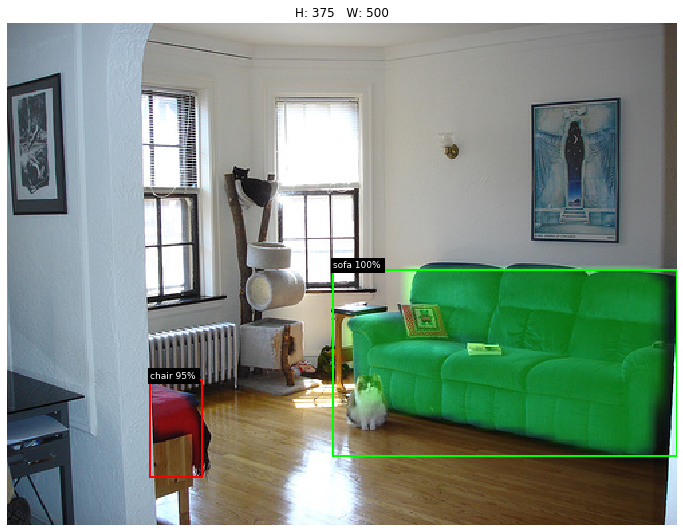

In [57]:
iters = 1

for i, (image, target) in enumerate(d):
    image = image.to(device)
    target = {k: v.to(device) for k, v in target.items()}
    
    with torch.no_grad():
        result = model(image)
        
    plt.figure(figsize=(12, 15))
    pmr.show(image, result, ds.classes)

    if i >= iters - 1:
        break

In [10]:
result.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [11]:
result['labels']

tensor([17, 17, 17], device='cuda:0')

In [12]:
result['masks'].shape

torch.Size([3, 375, 500])

In [13]:
result['boxes']

tensor([[334.1015, 180.2618, 482.4465, 323.4467],
        [264.8738, 182.6731, 500.0000, 342.0565],
        [295.0144, 181.7093, 478.9573, 281.9004]], device='cuda:0')

In [14]:
masks = result['masks'].cpu().numpy()
segmentation = masks[0,:,:]

In [15]:
rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
rle

{'size': [375, 500], 'counts': b'\\Sg5'}

In [19]:
len(cocoGt.imgs)

100

In [29]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/hw3/test.json")
coco_dt = []
jishu = 0
for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    jishu+=1
    if jishu%10 == 0:
        print(jishu)
    image = Image.open(os.path.join('/data/zihaosh/hw3/test_images', img_info["file_name"]))
    image.convert("RGB")
    transform1 = transforms.Compose([transforms.ToTensor()])
    image = transform1(image)
    image = image.to(device)
    with torch.no_grad():
        result = model(image)
    
#     plt.figure(figsize=(12, 15))
#     pmr.show(image, result, ds.classes)    
    
    masks = result['masks'].gt_(0.5)
    masks = masks.cpu().numpy()

    categories = result['labels']
    scores = result['scores']
    n_instances = len(scores)    
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])+1
            segmentation = masks[i,:,:]
            rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')
            pred['segmentation'] = rle
            pred['score'] = float(scores[i])
            coco_dt.append(pred)
#     if True:
#         break

print(len(coco_dt))
# coco_dt
with open("/output/0616109_.json", "w") as f:
    json.dump(coco_dt, f)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
10
20
30
40
50
60
70
80
90
100
310


In [124]:
len(coco_dt)

261

In [25]:
coco_dt[0]

{'image_id': 1005,
 'category_id': 18,
 'segmentation': {'size': [375, 500],
  'counts': 'gVj3e0[:P1\\N]NaG1b0i1g7[NcG00M30Mj1U8`NkGION30Nh1U8cNiGH1N2OOg1m7VNUH?LHON4ONf1n7VNUHj0K[O4ONe1o7XNSHi0L[O4ONe1o7WNTHj0K\\O2o1m7kMVHj0Kg1n7_MWHj0Kh1m7]MYHk0Jj1k7[M[Hc3d7]L\\Hb3e7_LZH`3g7aLWH`3i7aLVH^3k7cLSH^3m7bLSH^3m7aLUH_3j7aLVH`3i7_LXHc3f7]LZHc3f7]LZHd3e7]LYHc3h76O10O1O12N1O00WLYHc3f7\\L\\Hc3d7^LZHc3f78O1O001O00O1000000O11O001O00000000000000001O0000000000000000RL_Hf3a7ZL^Hg3b770001O01OO10QL_Hh3a7WLaHi3^7VLcHj3]7VLcHj3^7TLcHl3]7TLcHl3d7000000001O01O01O00O100O10000000000000000O10001O0O100000000O10001O00000000001O005K0O2N100O11O001N3I6N10O2YLTH`3m7_LUH_3R8N2O11O01O0001OO2M3M3M5D]G]MQ9l1nFUNj9h0ZFSO03^Q7'},
 'score': 0.7663878798484802}

In [27]:
coco_dt[0]

{'image_id': 1005,
 'category_id': 18,
 'segmentation': {'size': [375, 500], 'counts': '\\Sg5'},
 'score': 0.7663878798484802}

In [114]:
import numpy as np
from itertools import groupby
from pycocotools import mask as maskutil

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
#         print(i, (value, elements))
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

In [24]:
# binary_mask_to_rle(masks[0,:,:])

In [295]:
binary_mask = masks[0]
rle = {'counts': [], 'size': list(binary_mask.shape)}
counts = rle.get('counts')
for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
#     print(i, (value, elements))
    if i==0 and value != 0:
        print('yes')


In [144]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/hw3/test.json")

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [275]:
masks[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [115]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/hw3/test.json")
coco_dt = []
jishu = 0
for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    jishu+=1
    if jishu%10 == 0:
        print(jishu)
    image = Image.open(os.path.join('/data/zihaosh/hw3/test_images', img_info["file_name"]))
    image.convert("RGB")
    transform1 = transforms.Compose([transforms.ToTensor()])
    image = transform1(image)
    image = image.to(device)
    with torch.no_grad():
        result = model(image)
#     masks = np.array(result['masks'].cpu())
    masks = result['masks'].gt_(0.5)
    masks = masks.cpu().numpy()

    categories = result['labels']
    scores = result['scores']
    n_instances = len(scores)    
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])+1
            pred['segmentation'] = binary_mask_to_rle(masks[i,:,:]) # save binary mask to RLE, e.g. 512x512 -> rle
            pred['score'] = float(scores[i])
            coco_dt.append(pred)
#     if True:
#         break

print(len(coco_dt))
# coco_dt
with open("/output/0616109_6.json", "w") as f:
    json.dump(coco_dt, f)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
10
20
30
40
50
60
70
80
90
100
261


In [116]:
coco_dt[0]

{'image_id': 914,
 'category_id': 3,
 'segmentation': {'size': [333, 500],
  'counts': 'jd[13W:5L5L3N1N2O1N102N2M3N1O001O1O1O2N1O1O1O001O1O1O00100O001O1O1O100O001O100O100O2O0O00100O101O0O100O100O100O10O100O100001O0003M0O10O1002N1N10O010001O2M100O01O01O010O1O0010O01O1O1O00001O0000000O100O1OWGoNX8R1fGPOY8P1fGROY8o0eGRO\\8m0bGVO]8k0aGVO_8\\1001O1O1O1O00001O01N10000O10000O1O1O1N2N2M3O1O001M3M3M3O0001O000O2O0O1N3O001N1O2M3E:I8N2N2O1N2M3N2N1O200O2N1N2L4O1N2O100O1O1N2N3N1O1O4Koon1'},
 'score': 0.6174019575119019}

In [270]:
coco_dt[0]['score']
len(coco_dt)

261

In [261]:
masks

array([], shape=(0, 357, 500), dtype=float32)

In [206]:
result.keys()

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [247]:
print(ds.classes)
[ds.classes[i] for i in result['labels']]

('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


['bird', 'bird', 'bird', 'pottedplant']

In [221]:
import numpy as np
from itertools import groupby
from pycocotools import mask as maskutil

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

In [256]:
rle = {'counts': [], 'size': list(result['masks'].shape)}
rle.get('counts')

[]

In [255]:
b = binary_mask_to_rle(a)
rle = {'counts': [], 'size': list(a.shape)}
rle

{'counts': [], 'size': [4, 333, 500]}

In [226]:
import numpy as np
a = np.array(result['masks'].cpu())

In [237]:
a[0,66,126]

0.01772937

In [ ]:
coco_dt = []

for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    image = Image.open(os.path.join('/data/zihaosh/hw3/test_images', img_info["file_name"]))
    image.convert("RGB")
#         image = cv2.imread("test_images/" + coco.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1] # load image
    masks, categories, scores = model.predict(image) # run inference of your model
    n_instances = len(score)    
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])
            pred['segmentation'] = binary_mask_to_rle(masks[:,:,i]) # save binary mask to RLE, e.g. 512x512 -> rle
            pred['score'] = float(scores[i])
            coco_dt.append(pred)

In [306]:
import pycocotools

In [307]:
temp = np.asfortranarray(np.array(result['masks'].cpu()))
pycocotools.mask.encode(temp)

ValueError: Buffer dtype mismatch, expected 'uint8_t' but got 'float'

In [300]:
result['masks'].shape

torch.Size([4, 333, 500])

## validate the TRAIN

In [54]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/hw3/pascal_train.json")
coco_dt_train = []
jishu = 0
for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    jishu+=1
    if jishu%50 == 0:
        print(jishu)
    image = Image.open(os.path.join('/data/zihaosh/hw3/train_images', img_info["file_name"]))
    image.convert("RGB")
    transform1 = transforms.Compose([transforms.ToTensor()])
    image = transform1(image)
    image = image.to(device)
    with torch.no_grad():
        result = model(image)
    masks = result['masks'].gt_(0.5)
    masks = masks.cpu().numpy()

    categories = result['labels']
    scores = result['scores']
    n_instances = len(scores)
#     print(masks.shape)
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])+1
            segmentation = masks[i,:,:]
            rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')
            pred['segmentation'] = rle
            pred['score'] = float(scores[i])
            coco_dt_train.append(pred)
    else:
        pred = {'image_id':imgid,'category_id':0,'score':0.0,
                'segmentation':{'counts':'00','size':[masks.shape[1],masks.shape[2]]}}
        coco_dt_train.append(pred)
        
#     if jishu==2:
#         break

print(len(coco_dt_train))
# coco_dt


loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
4639


In [72]:
with open("/output/submission_train1.json", "w") as f:
    json.dump(coco_dt_train, f)

In [68]:
annsImgIds = [ann['image_id'] for ann in coco_dt_train]
# len(list(set(annsImgIds)))
list(set(annsImgIds))[-1]

1449

In [71]:
cocoGt = COCO("/data/zihaosh/hw3/pascal_train.json")
# len(list(set(cocoGt.getImgIds())))
list(set(cocoGt.getImgIds()))[-1]

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


1449

In [73]:
cocoDt = cocoGt.loadRes("/output/submission_train1.json")

Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!


In [74]:
cocoEval = COCOeval(cocoGt, cocoDt, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=1.75s).
Accumulating evaluation results...
DONE (t=0.25s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.098
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.221
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.152
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.128
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.161
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.162
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.008
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

In [45]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/data_hw3/val.json")
coco_dt_train = []
jishu = 0
for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    jishu+=1
    if jishu%50 == 0:
        print(jishu)
    image = Image.open(os.path.join('/data/zihaosh/data_hw3/train', img_info["file_name"]))
    image.convert("RGB")
    transform1 = transforms.Compose([transforms.ToTensor()])
    image = transform1(image)
    image = image.to(device)
    with torch.no_grad():
        result = model(image)
    masks = result['masks'].gt_(0.5)
    masks = masks.cpu().numpy()

    categories = result['labels']
    scores = result['scores']
    n_instances = len(scores)
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])+1
            segmentation = masks[i,:,:]
            rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')
            pred['segmentation'] = rle
            pred['score'] = float(scores[i])
            coco_dt_train.append(pred)
    else:
        pred = {'image_id':imgid,'category_id':0,'score':0.0,
                'segmentation':{'counts':'00','size':[masks.shape[1],masks.shape[2]]}}
        coco_dt_train.append(pred)

#     if jishu==2:
#         break

print(len(coco_dt_train))
with open("/output/submission_train1.json", "w") as f:
    json.dump(coco_dt_train, f)
cocoDt = cocoGt.loadRes("/output/submission_train1.json")
cocoEval = COCOeval(cocoGt, cocoDt, 'segm')
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()



3519

In [50]:
coco_dt_train[-1]

{'image_id': 345,
 'category_id': 17,
 'segmentation': {'size': [375, 500], 'counts': '\\Sg5'},
 'score': 0.32233065366744995}

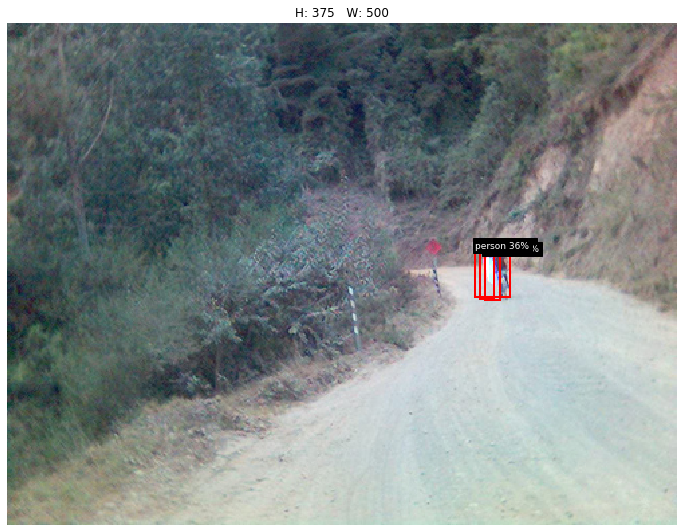

In [96]:
plt.figure(figsize=(12, 15))
pmr.show(image, result, ds.classes)

In [108]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
cocoGt = COCO("/data/zihaosh/hw3/pascal_train.json")
coco_dt_train = []
jishu = 0
for imgid in cocoGt.imgs:
    img_id = int(imgid)
    img_info = cocoGt.imgs[img_id]
    jishu+=1
    if jishu%10 == 0:
        print(jishu)
    image = Image.open(os.path.join('/data/zihaosh/hw3/train_images', img_info["file_name"]))
    image.convert("RGB")
    transform1 = transforms.Compose([transforms.ToTensor()])
    image = transform1(image)
    image = image.to(device)
    with torch.no_grad():
        result = model(image)
#     masks = result['masks']
    masks = result['masks'].gt_(0.5)
    masks = masks.cpu().numpy()
    categories = result['labels']
    scores = result['scores']
    n_instances = len(scores)    
    if len(categories) > 0: # If any objects are detected in this image
        for i in range(n_instances): # Loop all instances
            # save information of the instance in a dictionary then append on coco_dt list
            pred = {}
            pred['image_id'] = imgid # this imgid must be same as the key of test.json
            pred['category_id'] = int(categories[i])
            segmentation = masks[i,:,:]
            rle = pycocotools.mask.encode(np.asfortranarray(segmentation.astype(np.uint8)))
            rle['counts'] = rle['counts'].decode('ascii')
            pred['segmentation'] = rle
            pred['score'] = float(scores[i])
            coco_dt_train.append(pred)
    if jishu==3:
        break

print(len(coco_dt_train))
coco_dt_train[-1]

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
6


{'image_id': 890,
 'category_id': 14,
 'segmentation': {'size': [334, 500], 'counts': 'hRS5'},
 'score': 0.9791039228439331}

In [107]:
coco_dt_train[-1]

{'image_id': 890,
 'category_id': 14,
 'segmentation': {'size': [334, 500],
  'counts': 'Tnd36U:8G6M3L3M4WKTOIQ10LUO9g0NRO5k01nN2Q14eN2Y13\\N4c12TN3k1OPN4P2OfM9Y2LWM`0i2LaL>^3Z3N2O001O001O001O1O2N3M4L:F1O1O001O001O0000000000000O10000000000000000000000000000000000000hNTMmJm2j4fMlJZ2l4TNnJl1P5YNmJg1Q5^NkJc1Q5dNkJ]1o4T2L4M3N2J6H8L4O1M3J6K5N2N2K5K5M3N2N3K4N2N2cNeHE]73SIAR77[I_Oi6=g1M3L4JTP?'},
 'score': 0.9791039228439331}

In [86]:
masks = result['masks']
masks.shape

torch.Size([3, 375, 500])

In [87]:
masks.sum()

tensor(397.6824, device='cuda:0')

In [88]:
b = masks.gt_(0.5)

In [93]:
b.sum()

tensor(370., device='cuda:0')

In [92]:
for i in range(b[0].shape[0]):
    for j in range(b[0].shape[1]):
        if b[0][i][j]==1:
            print(i, j)

174 356
174 357
174 358
175 355
175 356
175 357
175 358
175 359
176 355
176 356
176 357
176 358
176 359
177 355
177 356
177 357
177 358
177 359
178 355
178 356
178 357
178 358
178 359
179 355
179 356
179 357
179 358
179 359
180 355
180 356
180 357
180 358
180 359
181 355
181 356
181 357
181 358
181 359
182 355
182 356
182 357
182 358
182 359
183 355
183 356
183 357
183 358
183 359
184 356
184 357
184 358
184 359
185 356
185 357
185 358
185 359
186 356
186 357
186 358
186 359
187 356
187 357
187 358
187 359
188 357
188 358
188 359
189 357
189 358
189 359
190 357
190 358
190 359
191 358
191 359
192 358
192 359
193 359


In [111]:
a = torch.rand(2,2)
a

tensor([[0.1916, 0.8466],
        [0.4271, 0.9441]])

In [112]:
a.gt_(0.5)

tensor([[0., 1.],
        [0., 1.]])